# Linear Model Selection & Regularization

This chapter deals specifically with linear models, but many of the techniques are applicable to non-linear techniques as well. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm.notebook import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

## Subset Selection

_Select a subset of predictors (features) can reduce model variability and improve computational costs, while having a negligible effect on predictive power._



### Forward-stepwise Selection

Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest _additional_ improvement to the fit is added to the model.


**Pseudo Code**
```
-let features=[]
-for k in 0,..,p-1:
    * train current model augmented with each of the remaining p-k features
    * choose the feature that gave the biggest increase in model performance
-Select the best model from all trained models
```

In [2]:
credit = pd.read_csv('../data/Credit.csv')

credit.drop(columns=['Gender','Ethnicity'], inplace=True)

credit[['Student','Married']] = credit[['Student','Married']].replace({'Yes': 1, 'No': 0})

credit.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance
0,14.891,3606,283,2,34,11,0,1,333
1,106.025,6645,483,3,82,15,1,1,903
2,104.593,7075,514,4,71,11,0,0,580
3,148.924,9504,681,3,36,11,0,0,964
4,55.882,4897,357,2,68,16,0,1,331


In [3]:
from sklearn.linear_model import LinearRegression

def rss(y, yhat):
    return sum((y-yhat)**2)

def stepwise_forward_selection(model, data, label, maximize=True):
    """
    Stepwise forward selection
    """
    X = data.drop(columns=label)
    y = data[label]
    
    features = X.columns.tolist()
    
    selected_features = []
    stepwise_scores = []
    for k in tqdm_notebook(range(len(features))):
        scores = []
        for j in range(len(features)):
            
            X_curr = X[selected_features + [features[j]]]
            
            model.fit(X_curr, y)
            
            preds = model.predict(X_curr)
            scores.append(rss(y, preds))
            
        # select feature with best additional score
        if maximize:
            best_feat, best_score = features[np.argmax(scores)], np.max(scores)
        else:
            best_feat, best_score = features[np.argmin(scores)], np.min(scores)
            
            
        # Remove from pool
        features.remove(best_feat)
        
        selected_features.append(best_feat)
        stepwise_scores.append(best_score)
        
    return selected_features, stepwise_scores

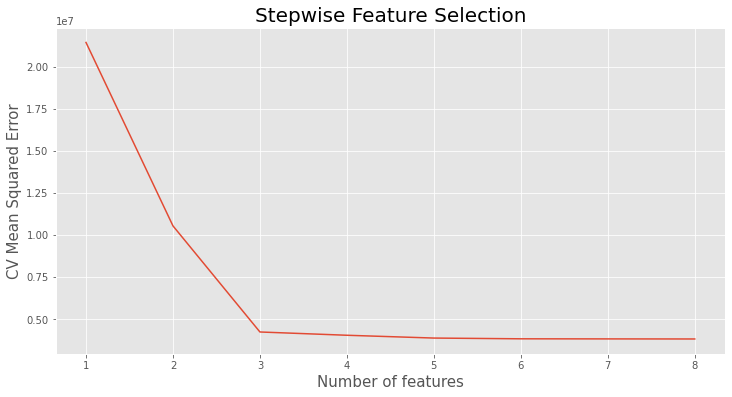

In [4]:
model = LinearRegression()
target = 'Balance'
metric = 'neg_mean_squared_error'
selected_features, stepwise_scores = stepwise_forward_selection(model, credit, target, maximize=False)

plt.figure(figsize=(12,6))
plt.plot(range(1,len(stepwise_scores)+1), stepwise_scores)
plt.title('Stepwise Feature Selection', fontsize=20)
plt.xlabel('Number of features', fontsize=15)
plt.ylabel('CV Mean Squared Error', fontsize=15)
plt.show()

### Selecting the best model

Considering $RSS$ and $R^2$ as evaluation metrics during features is misleading, because $RSS$ will always decrease (and $R^2$ increase) as we add more features to the model. Thus, although we can see that some features are _more important_ than others by considering the above graph, we still cannot make a decision about which combination of features will give the best results on unknown data.


#### Metrics for model selection

For selecting the best model after performing feature selection, there are three variables to consider:


**_Mallows $C_p$:_**
$$
C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)
$$

Where $\hat{\sigma}^2$ is an _estimate_ of the variance of the errors, estimated from the model trained using all the features, and $d$ is the number of features. 


**_Bayesian Information Criteria $BIC$:_**
$$
BIC = \frac{1}{n\hat{\sigma}^2}(RSS + log(n)d\hat{\sigma}^2)
$$

Similarly, $\hat{\sigma}^2$ is an estimate of the variance of the errors on the full model.

Because $BIC$ is now proportional to $log(n)$ rather than $2n$, the $BIC$ statistic generally places a heavier penalty on models with many variables, and hence results in the selection of smaller models than $C_p$.


**Estimating $\hat{\sigma}^2$**

Because $\hat{\sigma}^2$ is estimated on the training set of the full model, we can calculate is using:

$$
\hat{\sigma}^2 = \frac{RSS}{n-d-1}
$$

In [5]:
# Number of samples
n = credit.shape[0]

scores_df = pd.DataFrame(stepwise_scores, columns=['RSS'])

features_nested = []
for f in selected_features:
    features_nested.append(features_nested+[f])
    
    
# Error variance
sigma_est = scores_df['RSS'].min() / (n - scores_df.shape[1] - 1)

scores_df['features'] = features_nested

scores_df['num_features'] = scores_df.index

scores_df['Cp'] = (1/n) * (scores_df['RSS'] + 2*scores_df['num_features'] * sigma_est)

scores_df['BIC'] = (1/(sigma_est*n)) * (scores_df['RSS'] + np.log(n)*scores_df['num_features'] * sigma_est)

scores_df

,RSS,features,num_features,Cp,BIC
0,2.143512e+07,[Rating],0,53587.805082,5.595574
1,1.053254e+07,"[[Rating], Income]",1,26379.237321,2.764467
2,4.227219e+06,"[[Rating], [[Rating], Income], Student]",2,10663.816468,1.133460
3,4.032502e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",3,10224.906447,1.097608
4,3.866091e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",4,9856.764398,1.069146
5,3.821620e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",5,9793.469654,1.072516
6,3.816169e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",6,9827.727309,1.086071
7,3.811574e+06,"[[Rating], [[Rating], Income], [[Rating], [['R...",7,9864.123749,1.099851


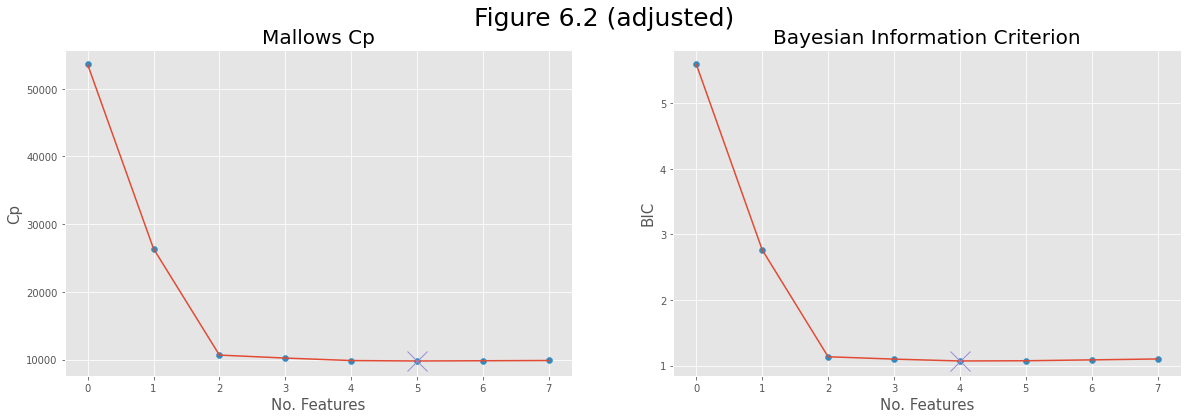

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

ax = axes[0]
metric = 'Cp'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Mallows Cp', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


ax = axes[1]
metric = 'BIC'
min_idx, min_val = scores_df[metric].idxmin(), scores_df[metric].min()
ax.plot(scores_df['num_features'], scores_df[metric], color=colors[0])
ax.scatter(scores_df['num_features'], scores_df[metric], color=colors[1])
ax.plot(min_idx, min_val, color=colors[2], marker='x', markersize=20)
ax.set_title('Bayesian Information Criterion', fontsize=20)
ax.set_xlabel('No. Features', fontsize=15)
ax.set_ylabel(metric, fontsize=15)


fig.suptitle('Figure 6.2 (adjusted)', fontsize=25);

**Notice** how when using BIC for model selection a model with less features is considered optimal. 

### Model selection using cross validation

In practice, using cross validation for model selection is much more appropriate. We are not constrained to linear models and are making much less assumptions about the data and the models when taking this approach. 

However, actually _selecting_ the best model is not always as easy. If we simply use the model with the lowest mean cross validation score, then using different folds and a different number of folds would give different results. 

One way to overcome this is to use the _one-standard-error rule_, where we select the model with the smallest cross validation score by one standard error (standard deviation in the case of means). When the difference between model performance is less than one standard error, then select the simplest model. 

In [7]:
from sklearn.model_selection import cross_val_score

def stepwise_forward_selection_cv(model, data, label, metric, maximize=True, cv=10):
    """
    Stepwise forward selection using cross-validation
    """
    X = data.drop(columns=label)
    y = data[label]
    
    features = X.columns.tolist()
    
    
    stepwise_results = {
        
    }
    
    stepwise_std = []
    stepwise_scores = []
    selected_features = []
    for k in tqdm_notebook(range(len(features))):
        std = []
        scores = []
        for j in range(len(features)):
            
            X_curr = X[selected_features + [features[j]]]
            
            cv_scores = cross_val_score(model, X_curr, y, scoring=metric, cv=cv)
            
            scores.append(-1*np.mean(cv_scores))
            std.append(np.std(cv_scores))
            
        # select feature with best additional score
        if maximize:
            best_idx = np.argmax(scores)
            
        else:
            best_idx = np.argmin(scores)
        
        best_feat, best_score ,best_std = features[best_idx], scores[best_idx], std[best_idx]
            
        # Remove from pool
        features.remove(best_feat)
        
        selected_features.append(best_feat)
        
        stepwise_results[k] = {
            'features': np.array(selected_features),
            'cv_mean': best_score,
            'cv_std': best_std
        }
        
        
    results_df = pd.DataFrame.from_dict(stepwise_results, orient='index')
    results_df['n_features'] = results_df.index+1
    
    results_df['cv_low'] = results_df['cv_mean'] - results_df['cv_std']
    results_df['cv_high'] = results_df['cv_mean'] + results_df['cv_std']
    
    return results_df

In [8]:
cv_stepwise_results = stepwise_forward_selection_cv(model, credit, target, metric='neg_mean_squared_error', maximize=False)

In [9]:
cv_stepwise_results

,features,cv_mean,cv_std,n_features,cv_low,cv_high
0,[Rating],54251.447982,15372.556508,1,38878.891474,69624.004490
1,"[Rating, Income]",26703.583806,8331.338939,2,18372.244867,35034.922745
2,"[Rating, Income, Student]",10865.870173,3269.576188,3,7596.293985,14135.446361
3,"[Rating, Income, Student, Limit]",10434.030961,2861.060965,4,7572.969996,13295.091926
4,"[Rating, Income, Student, Limit, Cards]",10036.229953,2598.787705,5,7437.442248,12635.017657
5,"[Rating, Income, Student, Limit, Cards, Age]",9936.271848,2607.553475,6,7328.718372,12543.825323
6,"[Rating, Income, Student, Limit, Cards, Age, M...",9968.606350,2624.290612,7,7344.315738,12592.896962
7,"[Rating, Income, Student, Limit, Cards, Age, M...",10021.108586,2706.811281,8,7314.297306,12727.919867


<ErrorbarContainer object of 3 artists>

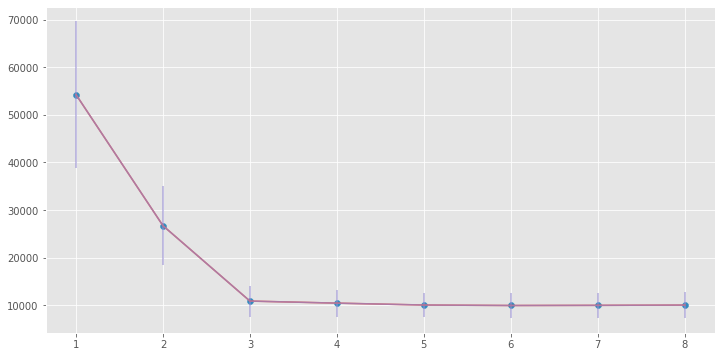

In [10]:
errors = np.c_[cv_stepwise_results['cv_low'], cv_stepwise_results['cv_high']].T

plt.figure(figsize=(12,6))
plt.plot(cv_stepwise_results['n_features'], cv_stepwise_results['cv_mean'], color=colors[0])
plt.scatter(cv_stepwise_results['n_features'], cv_stepwise_results['cv_mean'], color=colors[1])
plt.errorbar(cv_stepwise_results['n_features'], 
             cv_stepwise_results['cv_mean'], 
             yerr=cv_stepwise_results['cv_std'],
             color=colors[2], alpha=0.7)

From this graph, we cannot distinguish between the models (using the one-standard-error rule) with features 3,4..8. Thus we would choose the simplest model with 3 features. 



## Shrinkage Methods / Regularization

Shrinking methods can significantly reduce the variance of model coefficients and in effect improve the model performance on unseen (test) data. 

### Ridge Regression

Also called _l2 regularized regression_.

**Penalty Term**

$$
\lambda\sum_{j=1}^{p}\beta_j^2
$$

**L2 Norm**:

$$
||{\beta}||_2 = \sqrt{\sum_i^p\beta^2}
$$

* When $\lambda = 0$, the penalty term has no effect, and ridge regression will produce the least squares estimates.
* As $\lambda \to \inf$ the penalty grows and the coefficient will tend to zero, but will never actually be zero. 
* When using Ridge Regression, it's best to standardize all predictors to have unit variance. 


#### Figure 6.4

In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def l2_norm(coefs):
    return np.sqrt(sum(coefs**2))


scaler = StandardScaler(with_mean=True, with_std=True)

cols = ['Income','Limit','Rating','Student']
X = credit[cols]
y = credit.Balance

X = pd.DataFrame(scaler.fit_transform(X), columns=cols)


# Get linear regression coefficients
lr = LinearRegression()
lr.fit(X, y)

# Calculate L2 Norm of Linear Regression
lr_l2 = l2_norm(lr.coef_)

# Get Ridge Regression coefficients
rr_coefs = {}
l2_norms = []
for lambda_ in tqdm_notebook(np.linspace(2e-2, 1e4, 10000)):
    rr = Ridge(lambda_, random_state=0, )
    rr.fit(X, y)
    rr_coefs[lambda_] = rr.coef_
    l2_norms.append(l2_norm(rr.coef_)/lr_l2)


In [12]:
rr_coefs = pd.DataFrame.from_dict(rr_coefs, orient='index', columns=cols)
l2_coefs = rr_coefs.copy()
l2_coefs.index = l2_norms

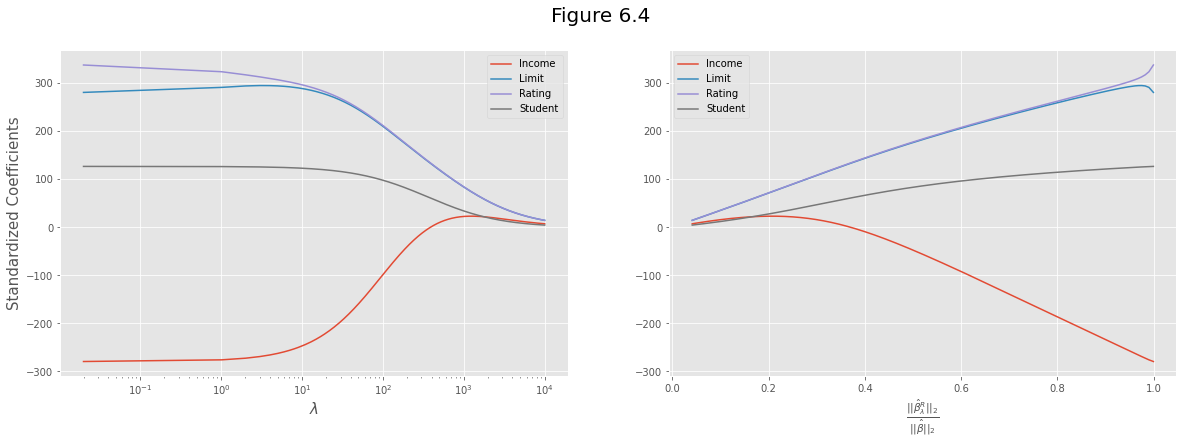

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

ax=axes[0]
rr_coefs.plot(ax=ax, logx=True)
ax.set_xlabel('$\lambda$', fontsize=15);
ax.set_ylabel('Standardized Coefficients', fontsize=15)


ax=axes[1]
l2_coefs.plot(ax=ax)
ax.set_xlabel(r"$\frac{||\hat{\beta}^R_\lambda||_2}{||\hat{\beta}||_2}$", fontsize=15) #

fig.suptitle('Figure 6.4', fontsize=20)
plt.show()

### Lasso Regression

**Penalty Term**: 
$$
\lambda \sum_{j=0}^{p}|\beta_j|
$$

**L1 Norm**:

$$
||\beta||_1 = \sum_j^p|\beta_j|
$$

* As $\lambda \to \inf$ the penalty grows and the coefficient will **become zero**.
* Lasso performs feature selection.

#### Figure 6.6

In [14]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def l1_norm(coefs):
    return sum(abs(coefs))


scaler = StandardScaler(with_mean=False, with_std=True)

cols = ['Income','Limit','Rating','Student']
X = credit[cols]
y = credit.Balance

X = pd.DataFrame(scaler.fit_transform(X), columns=cols)

# Get linear regression coefficients
lr = LinearRegression()
lr.fit(X, y)

# Calculate L1 Norm of Linear Regression
lr_l1 = l1_norm(lr.coef_)

# Get Ridge Regression coefficients
lasso_coefs = {}
l1_norms = []
for lambda_ in tqdm_notebook(np.linspace(20, 6000, 1000)):
    lasso = Lasso(lambda_, random_state=0)
    lasso.fit(X, y)
    lasso_coefs[lambda_] = lasso.coef_
    l1_norms.append(l1_norm(lasso.coef_)/lr_l1)

    
lasso_coefs = pd.DataFrame.from_dict(lasso_coefs, orient='index', columns=cols)
l1_coefs = lasso_coefs.copy()
l1_coefs.index = l1_norms

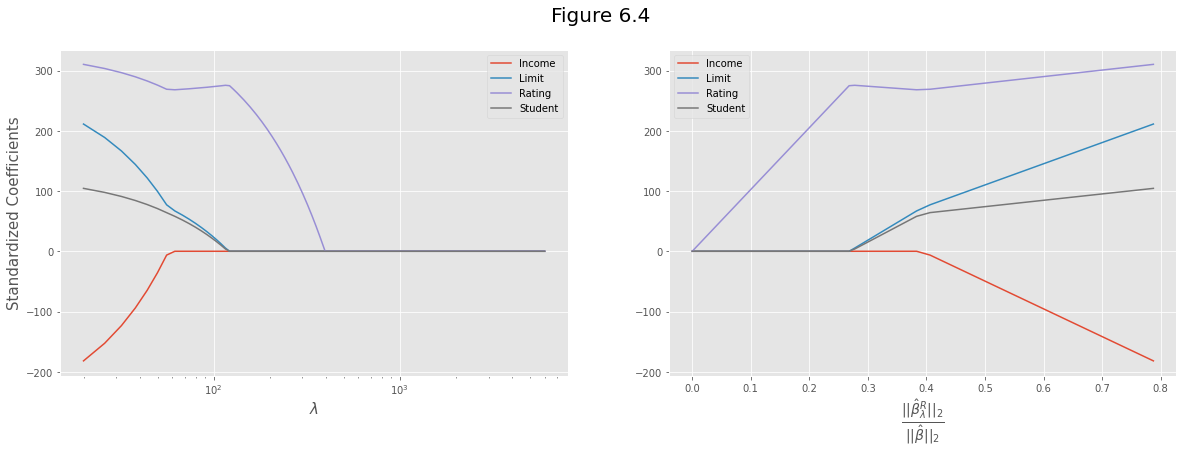

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

ax=axes[0]
lasso_coefs.plot(ax=ax,logx=True)
ax.set_xlabel('$\lambda$', fontsize=15);
ax.set_ylabel('Standardized Coefficients', fontsize=15)

ax=axes[1]
l1_coefs.plot(ax=ax)
ax.set_xlabel(r"$\frac{||\hat{\beta}^R_\lambda||_2}{||\hat{\beta}||_2}$", fontsize=20) #

fig.suptitle('Figure 6.4', fontsize=20)
plt.show()

### Comparison

* Lasso implicitly assumes some predictors have zero effect. Where this is not true, Ridge will outperform Lasso. 
* Ridge regression more or less shrinks every dimension of the data by the same proportion, whereas the lasso more or less shrinks all coefficients toward zero by a similar amount, and sufficiently small coefficients are shrunken all the way to zero.

### Selecting $\lambda$

Using cross validation to select the best value for $\lambda$. 

In [22]:
scores = {}

for lambda_ in tqdm_notebook(np.linspace(5e-3, 5, 1000)):
    rr = Ridge(lambda_, random_state=0)
    
    cv_score = cross_val_score(rr, X, y, cv=5, scoring='neg_mean_squared_error')

    scores[lambda_] = np.sqrt(-1*(np.mean(cv_score)))

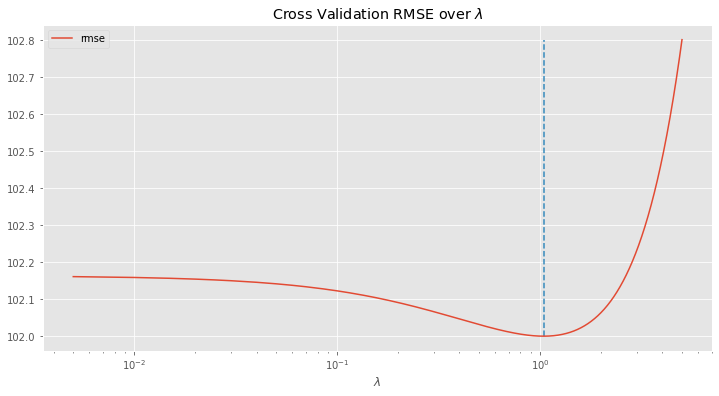

In [23]:
scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['rmse'])
ax = scores_df.plot(logx=True, figsize=(12,6))
ax.set_xlabel('$\lambda$');
ax.vlines(scores_df.rmse.idxmin(), scores_df.rmse.min(), scores_df.rmse.max(), colors[1], '--')
ax.set_title('Cross Validation RMSE over $\lambda$');

## Dimensionality Reduction

Dimensionality reduction is another method for _reducing variance_ in the model. Where regularization and feature selection uses a subset (or shrunken) version of the original features, dimensionality reduction aims to find a new _transformed_ set of features such that the new data set has a lower dimensionality than the original. 



### Principal Component Analysis

PCA is described in more detail in [Chapter 10](./Chapter-10.ipynb).


**Practical Use**

* Usually a good idea to standardise features before performing PCA. But if all are measured in same units then not necessarily. 
* PCA is not a feature selection model - principal components are a linear combination of original features. 


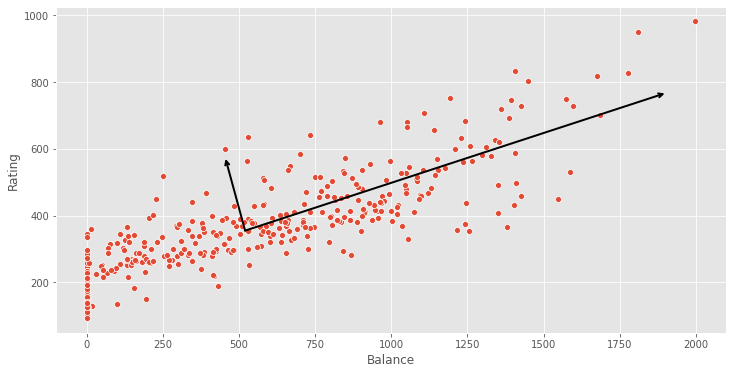

In [57]:
from sklearn.decomposition import PCA

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

X = credit[['Balance','Rating']]

pca = PCA(2)
pca.fit(X)

fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=credit,x='Balance',y='Rating', ax=ax)

# Show the principal component vectors
for length, vector in zip(pca.explained_variance_, pca.components_):
    # I'm not sure why this is necessary
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_+v, ax)
     
plt.show()

### Principal Component Regression

_Principal Component Regression_ (PCR) involved constructing the principal components $Z_1, Z_2, \ldots, Z_M$, and then using these components as predictors in a linear regression model that is fit using least squares. 

Although not always true, we can often make the assumption that the directions in which $X_1, X_2, \ldots, X_p$ show the most variation are the directions that are associated with the target $Y$. 

If this assumption is true, then fitting a linear regression model using $Z_1, Z_2, \ldots, Z_M$ would lead to better results, since most of the information relating to $Y$ is contained in this reduced dataset, and by estimating only $M << p$ coefficients we can reduce the variance of the model and reduce overfitting. 


### Partial Least Squares

Like PCR, _Partial Least Squares_ (PLS) is a dimensionality reduction technique which identifies a new set of features $Z_1, Z_2, \ldots Z_M$ as a linear combination of the original features and then fits a linear model to the reduced feature set using least squares.

Unlike PCR, PLS is a _supervised_ process, which means it uses the target variable in the selection of the reduced feature set. Roughly speaking, the PLS approach attempts to find directions that help explain both the response and the predictors.

How PLS works, can be summarized as:

1. To obtain the first direction/component $Z_1$, a linear regression model is fit using $Y$ unto $X$ and the weights for linearly combining the predictors in $X$ is set to the coefficients of the linear model. 
2. The second component, $Z_2$, is obtained by fitting a regression model of $Y$ unto $Z_1$, and then the residuals are calculated for each coefficient. These residuals represent the remaining information that has not been captured by the projection unto $Z_1$.
3. This process can be repeated $M$ times to obtain the PLS components $Z_1, Z_2, \ldots, Z_M$